In [1]:
#pip install socceraction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage

import tqdm
import os

import socceraction.spadl as spadl
from socceraction.data.statsbomb import StatsBombLoader

C:\Users\frede\Anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\frede\Anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\frede\Anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [3]:
# path to the STATSBOMB free data
datafolder = r'C:/Users/frede/Documents/FootballAnalyst/Statsbomb/open-data-master/data'
SBL = StatsBombLoader(root=datafolder, getter="local")

In [4]:
# View all available competitions from STATSBOMB
competitions = SBL.competitions()
set(competitions.competition_name)

{'Champions League',
 "FA Women's Super League",
 'FIFA World Cup',
 'La Liga',
 'NWSL',
 'Premier League',
 'UEFA Euro',
 "Women's World Cup"}

In [5]:
# For this challenge I've chosen to use Euro2021 data
selected_competitions = competitions[competitions.competition_name == "UEFA Euro"]
selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
38,43,55,UEFA Euro,Europe,male,2020


In [6]:
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])
games.head()

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,3788753,43,55,Group Stage,2,2021-06-16 15:00:00,1835,796,0,1,Saint-Petersburg Stadium,Danny Desmond Makkelie
1,3788765,43,55,Group Stage,3,2021-06-20 18:00:00,773,909,3,1,Bakı Olimpiya Stadionu,Slavko Vinčić
2,3795107,43,55,Quarter-finals,5,2021-07-02 21:00:00,782,914,1,2,Allianz Arena,Slavko Vinčić
3,3795221,43,55,Semi-finals,6,2021-07-07 21:00:00,768,776,2,1,Wembley Stadium,Danny Desmond Makkelie
4,3795506,43,55,Final,7,2021-07-11 21:00:00,914,768,1,1,Wembley Stadium,Björn Kuipers


In [7]:
events = pd.concat([
    SBL.events(row.game_id)
    for row in games.itertuples()
])
events.head()

,game_id,event_id,period_id,team_id,player_id,type_id,type_name,index,timestamp,minute,...,team_name,duration,extra,related_events,player_name,position_id,position_name,location,under_pressure,counterpress
0,3788753,9427b18a-6b10-411f-90da-3d6240b80c71,1,1835,NaN,35,Starting XI,1,1900-01-01 00:00:00.000,0,...,Finland,0.000000,"{'tactics': {'formation': 352, 'lineup': [{'pl...",[],NaN,NaN,NaN,NaN,False,False
1,3788753,542c58bf-5c6c-43ca-9d8d-e086c7f08aaf,1,796,NaN,35,Starting XI,2,1900-01-01 00:00:00.000,0,...,Russia,0.000000,"{'tactics': {'formation': 3421, 'lineup': [{'p...",[],NaN,NaN,NaN,NaN,False,False
2,3788753,a0dfe8a0-a0b9-443e-89e3-a8ba6596fa33,1,1835,NaN,18,Half Start,3,1900-01-01 00:00:00.000,0,...,Finland,0.000000,{},[c7156352-f4b7-4140-aa51-6e26fd019a11],NaN,NaN,NaN,NaN,False,False
3,3788753,c7156352-f4b7-4140-aa51-6e26fd019a11,1,796,NaN,18,Half Start,4,1900-01-01 00:00:00.000,0,...,Russia,0.000000,{},[a0dfe8a0-a0b9-443e-89e3-a8ba6596fa33],NaN,NaN,NaN,NaN,False,False
4,3788753,94dbc5c3-ef37-445e-9154-3d9f9ea9245d,1,796,6299.0,30,Pass,5,1900-01-01 00:00:00.490,0,...,Russia,1.373215,"{'pass': {'recipient': {'id': 31917, 'name': '...",[c0935bbe-3eb4-4a21-9eee-45f380d1f26d],Aleksey Miranchuk,18.0,Right Attacking Midfield,"[60.0, 40.0]",False,False


In [8]:
events.columns

Index(['game_id', 'event_id', 'period_id', 'team_id', 'player_id', 'type_id',
       'type_name', 'index', 'timestamp', 'minute', 'second', 'possession',
       'possession_team_id', 'possession_team_name', 'play_pattern_id',
       'play_pattern_name', 'team_name', 'duration', 'extra', 'related_events',
       'player_name', 'position_id', 'position_name', 'location',
       'under_pressure', 'counterpress'],
      dtype='object')

In [9]:
shots = events.loc[events['type_name']=='Shot']
shots.head()

,game_id,event_id,period_id,team_id,player_id,type_id,type_name,index,timestamp,minute,...,team_name,duration,extra,related_events,player_name,position_id,position_name,location,under_pressure,counterpress
49,3788753,91f2f8aa-4ee8-4593-97a6-1a7862a7cca5,1,796,20845.0,16,Shot,50,1900-01-01 00:00:29.166,0,...,Russia,0.257779,"{'shot': {'statsbomb_xg': 0.036601424, 'end_lo...","[4e5ffb57-b5c8-44f0-b33f-8d21dfab5a77, 76e2a3f...",Magomed Ozdoev,9.0,Right Defensive Midfield,"[99.9, 48.2]",False,False
430,3788753,0bb2daca-ab0b-497c-ac59-3cc559be6fb7,1,796,20845.0,16,Shot,431,1900-01-01 00:09:42.014,9,...,Russia,0.573803,"{'shot': {'statsbomb_xg': 0.23458281, 'end_loc...",[defbd524-173b-49cd-aaa3-f2c279e2f4db],Magomed Ozdoev,9.0,Right Defensive Midfield,"[109.6, 49.0]",False,False
855,3788753,1215b0dc-81fb-4416-b9a6-0faf150a4e8d,1,1835,9725.0,16,Shot,856,1900-01-01 00:19:53.988,19,...,Finland,0.033893,"{'shot': {'statsbomb_xg': 0.28013524, 'end_loc...","[609291e4-de5e-421f-b4b7-33564421beff, a9266da...",Joel Pohjanpalo,24.0,Left Center Forward,"[107.2, 45.3]",False,False
864,3788753,1ce72d1b-a7c5-4eb3-965f-61621b798f35,1,1835,26939.0,16,Shot,865,1900-01-01 00:20:38.796,20,...,Finland,1.258832,"{'shot': {'statsbomb_xg': 0.014892562, 'end_lo...","[7f642e88-7ab3-4eb3-bcd4-386010e0a6dd, d28ee04...",Joona Toivio,3.0,Right Center Back,"[110.9, 29.6]",True,False
1081,3788753,7aa54ce6-106a-4e26-9fb1-77aa0d76f793,1,796,5195.0,16,Shot,1082,1900-01-01 00:29:01.200,29,...,Russia,0.077448,"{'shot': {'statsbomb_xg': 0.13386948, 'end_loc...","[1c9be059-8657-4109-a7be-47477154deb4, 31eeda3...",Artem Dzyuba,23.0,Center Forward,"[114.8, 42.1]",True,False


In [10]:
pd.DataFrame.from_dict(shots.extra.iloc[2])

,shot
body_part,"{'id': 40, 'name': 'Right Foot'}"
end_location,"[108.1, 44.8]"
freeze_frame,"[{'location': [105.9, 32.3], 'player': {'id': ..."
key_pass_id,8c91e4ea-c7ec-445c-b7da-1e886a87a594
outcome,"{'id': 96, 'name': 'Blocked'}"
statsbomb_xg,0.280135
technique,"{'id': 93, 'name': 'Normal'}"
type,"{'id': 87, 'name': 'Open Play'}"


In [11]:
shots = pd.concat([shots.drop(['extra'], axis=1), shots['extra'].apply(pd.Series)], axis=1)
shots = pd.concat([shots.drop(['shot'], axis=1), shots['shot'].apply(pd.Series)], axis=1)
shots = pd.concat([shots.drop(['outcome'], axis=1), shots['outcome'].apply(pd.Series)], axis=1)

In [12]:
shots = shots[['location','name']]
shots = shots.reset_index(drop=True)

In [13]:
shots.head()

,location,name
0,"[99.9, 48.2]",Blocked
1,"[109.6, 49.0]",Off T
2,"[107.2, 45.3]",Blocked
3,"[110.9, 29.6]",Off T
4,"[114.8, 42.1]",Blocked


In [14]:
shots.loc[shots['name'] =='Goal']

,location,name
7,"[108.7, 50.5]",Goal
30,"[99.8, 28.0]",Goal
37,"[98.4, 40.1]",Goal
55,"[97.4, 48.6]",Goal
59,"[105.1, 44.4]",Goal
...,...,...
1248,"[107.6, 37.7]",Goal
1254,"[109.2, 45.7]",Goal
1260,"[102.5, 49.2]",Goal
1277,"[113.3, 40.4]",Goal


## Plotting every shot of the tournament

In [22]:
def draw_half_pitch(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    Pitch = Rectangle([60,0], width = 60, height = 80, fill = False)
    #Right Penalty Area
    RightPenalty = Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False)

    #Right 6-yard Box
    RightSixYard = Rectangle([115.1,32], width = 4.9, height = 16, fill = False)


    #Prepare Circles
    centreCircle = Arc((60,40),width = 8.1, height = 8.1, angle=0,theta1=270,theta2=90,color="black")
    centreSpot = plt.Circle((60,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")
    
    element = [Pitch, RightPenalty, RightSixYard, centreCircle, centreSpot, rightPenSpot, rightArc]
    for i in element:
        ax.add_patch(i)

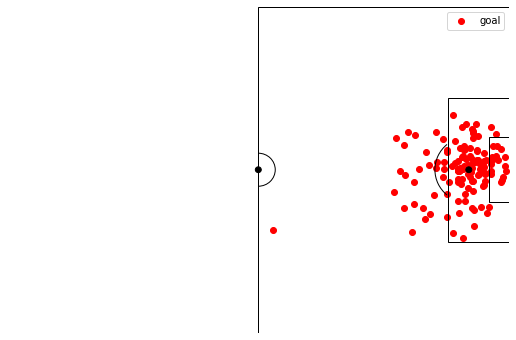

In [23]:
#Plotting every shot that lead to a GOAL
fig=plt.figure()
fig.set_size_inches(9, 6)
ax=fig.add_subplot(1,1,1)
draw_half_pitch(ax)
plt.axis('off')
# draw the scatter plot for goals
x_coord_goal = [location[0] for i, location in enumerate(shots["location"]) if shots.iloc[i]['name'] == "Goal"]
y_coord_goal = [location[1] for i, location in enumerate(shots["location"]) if shots.iloc[i]['name'] == "Goal"]

# put the two scatter plots on to the pitch
ax.scatter(x_coord_goal, y_coord_goal, c = 'red', label = 'goal')
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.legend(loc='upper right')
plt.axis('off')
plt.show()

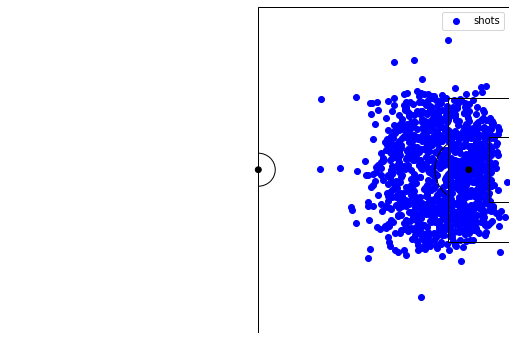

In [25]:
#Plotting every shot that didn't lead to a GOAL
fig=plt.figure()
fig.set_size_inches(9, 6)
ax=fig.add_subplot(1,1,1)
draw_half_pitch(ax)
plt.axis('off')
# shots that end up with no goal
x_coord = [location[0] for i, location in enumerate(shots["location"]) if shots.iloc[i]['name'] != "Goal"]
y_coord = [location[1] for i, location in enumerate(shots["location"]) if shots.iloc[i]['name'] != "Goal"]

ax.scatter(x_coord, y_coord, c = 'blue', label = 'shots')
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.legend(loc='upper right')
plt.axis('off')
plt.show()

In [32]:
(shots['location'][0])[0]

99.9

In [ ]:
#############

## xGoals

In [26]:
shots_model=pd.DataFrame(columns=['Goal','X','Y'])

In [35]:
for i,shot in shots.iterrows():  
    shots_model.at[i,'X']=100-(shots['location'][i])[0]
    shots_model.at[i,'Y']=(shots['location'][i])[1]
    shots_model.at[i,'C']=abs((shots['location'][i])[1]-50)
    
    #Distance in metres and shot angle in radians.
    x=shots_model.at[i,'X']*105/100
    y=shots_model.at[i,'C']*65/100
    shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
    a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
    if a<0:
        a=np.pi+a
    shots_model.at[i,'Angle'] =a

In [36]:
shots_model

,Goal,X,Y,C,Distance,Angle
0,NaN,0.1,48.2,1.8,1.174702,3.077713
1,NaN,-9.6,49.0,1.0,10.100936,2.447357
2,NaN,-7.2,45.3,4.7,8.153933,2.335464
3,NaN,-10.9,29.6,20.4,17.516153,2.863472
4,NaN,-14.8,42.1,7.9,16.366424,2.721212
...,...,...,...,...,...,...
1284,NaN,4.5,31.6,18.4,12.859519,0.223777
1285,NaN,0.6,48.8,1.2,1.002646,2.785284
1286,NaN,5.1,40.8,9.2,8.027230,0.654913
1287,NaN,-4.5,32.4,17.6,12.377367,2.899065


In [ ]:
################

In [ ]:
games_verbose = tqdm.tqdm(list(games.itertuples()))
teams, players = [], []
actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    # convert data
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(events, game.home_team_id)

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

In [ ]:
datafolder = r'C:/Users/frede/Documents/FootballAnalyst'

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

In [ ]:
pd.DataFrame(list(actions.items())) 

In [ ]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select Portugal vs Belgium game at Euro2021
    game = games[(games.competition_name == "UEFA Euro") 
                 & (games.away_team_name == "Portugal")
                 & (games.home_team_name == "Belgium")]
    
    game_id = game.game_id.values[0]
    actions = (
        spadlstore[f"actions/game_{game_id}"]
        .merge(spadl.actiontypes_df(), how="left")
        .merge(spadl.results_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)
del actions['nickname']
actions[:5]

In [ ]:
actions.loc[actions['type_name'] == 'shot']

In [ ]:
##############################